In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='4'

In [1]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import random
from sklearn.utils.class_weight import compute_class_weight
import importlib
from pathlib import Path
import re

from torch.utils.data import Dataset, DataLoader
from torch.nn import Module, Sequential, Conv2d, BatchNorm2d
from torch.nn import SiLU as ReLU
from torch.optim import SGD, Adam
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss
from torchvision.transforms import Compose, ToTensor, RandomAffine, RandomHorizontalFlip, RandomVerticalFlip, ColorJitter, Resize
import torch

import utils
import dataset 
import ResNet18_blocks
import ResNet50_blocks
import training_functions
from dataset import indexing_labels, check_unbalance_dataset, ImageDataset
from utils import plot_losses, exponential_moving_average
from ResNet18_blocks import BasicBlock, ResNet18
from ResNet50_blocks import MainPath, IdentityBlock, ConvolutionalBlock, ResNet50
from training_functions import network_training, transforms_train, transforms, FocalLoss, evaluate_network

seed = 0
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

In [3]:
volume_dir = "/mnt/home/u0053/disk/gaia_dataset/CompCars/"

In [16]:
# dataset.py
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict


class ImageDataset_Part(Dataset):

    def __init__(self, dataset_folder,  dataset_type, part, dict_labels, transform=None , label_type='model_id'):
        '''
        dataset_folder should be volume_dir + 'data/'
        dataset_type:  'train', 'test_updated', 'valid'
        label_type='model_id', 'make_id'

        Note:
        change arg wrt imageDataset function. Here I build the path to the txt file inside the funzion, 
        provided the arguments 'part' and 'dataset_type'.
        '''
        path_txt_file = dataset_folder + 'train_test_split/part/' + dataset_type + '_part_' + str(part) + '.txt'

        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.dict_labels=dict_labels

        ### safety checks
        # check if dataset_type is valid
        if dataset_type not in ['train', 'test_updated', 'valid']:
            raise ValueError("dataset_type must be 'train', 'test_updated', or 'valid'")
        # check if part is valid
        if part not in [1,2,3,4,5,6,7,8]:
            raise ValueError("part must be an integer between 0 and 8")
        
        # load the paths to the images you need
        with open(path_txt_file, 'r') as f:
            for line in f:
                relative_path = line.strip() # get the paths of the images used in the paper

                image_path = os.path.join(dataset_folder, 'part', relative_path)
                self.image_paths.append(image_path)

        # Extract label model_id from path
        for path in self.image_paths:
            name_parts = os.path.normpath(path).split(os.sep)
            model_id = name_parts[-4]
            make_id = name_parts[-5]
            if label_type == 'model_id':
              self.labels.append(model_id)
            elif  label_type == 'make_id':
              self.labels.append(make_id)
            else:
              raise Exception('error with label_type argument')
            
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.dict_labels[int(self.labels[idx])] #labelling the image, converting the original label to index through the dictionary
        if self.transform:
            image = self.transform(image)
        return image, label
    
def indexing_label_part(path_txt_file, label_type='model_id'): 
    '''
    This function reads a text file containing paths to images and extracts labels based on the specified label_type.
    It returns a dictionary mapping original labels to class indices for training.
    '''
    labels=[]

    with open(path_txt_file, 'r') as f:
        for line in f:
            path = line.strip()
            parts = os.path.normpath(path).split(os.sep)
            
            model_id = parts[-4] 
            make_id = parts[-5] 

            if label_type == 'model_id':
              labels.append(int(model_id))
            elif label_type == 'make_id':
              labels.append(int(make_id))
            else:
              raise Exception('error with label_type argument')

    unique_labels = sorted(set(labels)) # Map original labels to class indices
    label_to_index = {label: idx for idx, label in enumerate(unique_labels)}

    return label_to_index


def dataset_factory(volume_dir, label_to_index, transforms_train, transforms):
    '''
    This function creates a dataset factory that generates train, test, and validation datasets based on the specified viewpoint.
    It returns a function that can be called with a specific viewpoint to generate the datasets.
    '''
    def generate(viewpoint):
        train_dataset = ImageDataset_Part(volume_dir + "data", volume_dir + "data/train_test_split/classification/train.txt", label_to_index, transforms_train, viewpoint)
        test_dataset = ImageDataset(volume_dir + "data", volume_dir + "data/train_test_split/classification/test_updated.txt", label_to_index, transforms, viewpoint)
        valid_dataset = ImageDataset(volume_dir + "data", volume_dir + "data/train_test_split/classification/valid.txt", label_to_index, transforms, viewpoint)
        return train_dataset, test_dataset, valid_dataset
    return generate
# Ti chiederai perchè serve questa? Così non devi duplicare il codice ogni volta che devi generare dataset per un diverso viewpoint. 
# In più, se cambia qualcosa devi solo aggiornare la factory!


Set parameters of interest:

In [5]:
part = 1 # you can change this to any part you want to use
label_type = 'model_id'

Retrieve data:


In [7]:
label_to_index = indexing_label_part(volume_dir + "data/train_test_split/part/train_part_"+str(part)+".txt", label_type='model_id')   
print("Nr of models in the train dataset: ", len(label_to_index))


Nr of models in the train dataset:  431


In [17]:
train_dataset =  ImageDataset_Part(dataset_folder=volume_dir +'data/', 
                                   dict_labels=label_to_index, 
                                   dataset_type='train',
                                   part=part,
                                   transform=transforms_train, 
                                   label_type=label_type)
test_dataset =  ImageDataset_Part(dataset_folder=volume_dir +'data/', 
                                   dict_labels=label_to_index, 
                                   dataset_type='test_updated',
                                   part=part,
                                   transform=transforms, 
                                   label_type=label_type)
valid_dataset =  ImageDataset_Part(dataset_folder=volume_dir +'data/', 
                                   dict_labels=label_to_index, 
                                   dataset_type='valid',
                                   part=part,
                                   transform=transforms, 
                                   label_type=label_type)

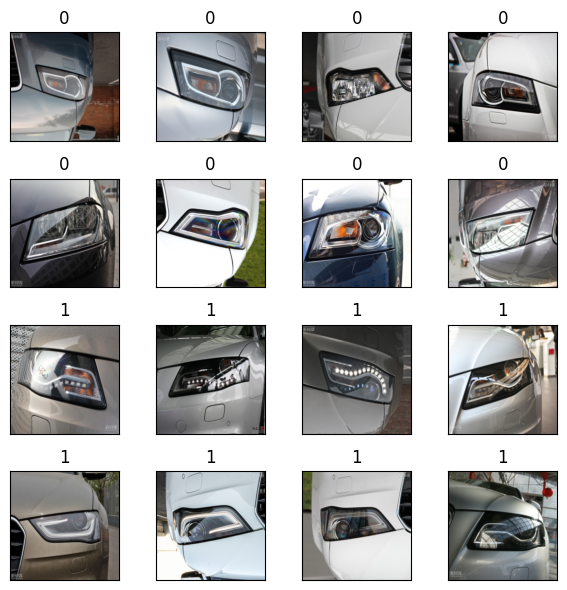

In [18]:
fig, axs = plt.subplots(4, 4, figsize=(6,6))
for i in range(16):
    axs[i//4][i%4].imshow(train_dataset[i][0].permute(1, 2, 0).numpy())
    axs[i//4][i%4].set_xticks([])
    axs[i//4][i%4].set_yticks([])
    axs[i//4][i%4].set_title(f"{train_dataset[i][1]}")
plt.tight_layout()